In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning

In [119]:
food_fact = pd.read_csv("en.openfoodfacts.org.products.tsv", sep='\t', low_memory=False)

In [120]:
food_fact.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
food_fact.shape

(356027, 163)

There are 356,027 rows and 163 columns in our data.

In [122]:
nan_percentage = food_fact.isnull().mean()

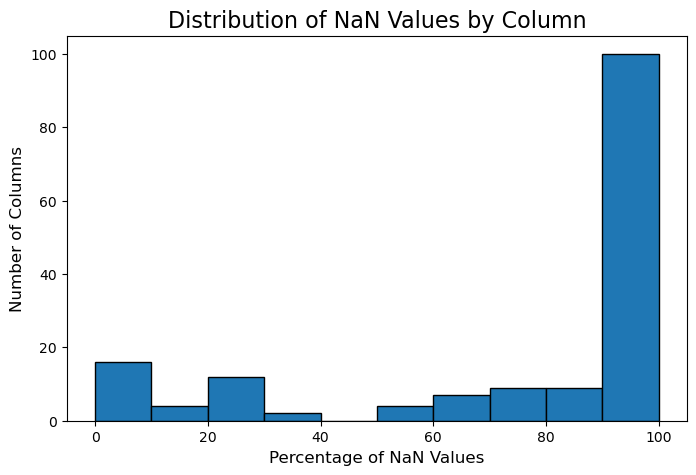

In [123]:
plt.figure(figsize=(8, 5))
plt.hist(nan_percentage * 100, bins=range(0, 101, 10), edgecolor='black')
plt.title('Distribution of NaN Values by Column', fontsize=16)
plt.xlabel('Percentage of NaN Values', fontsize=12)
plt.ylabel('Number of Columns', fontsize=12)
plt.show()

### Drop Columns with more than 50% Nan values

In [124]:
columns_to_drop = nan_percentage[nan_percentage > 0.5].index
food_fact = food_fact.drop(columns = columns_to_drop)

### Drop columns that provide similar information

In [125]:
food_fact = food_fact.drop(columns=[
    'created_datetime', 
    'last_modified_datetime', 
    'brands_tags', 
    'countries_tags', 
    'countries', 
    'additives', 
    'ingredients_that_may_be_from_palm_oil_n', 
    'states_tags', 
    'states_en'
])

### Drop columns that we don't have interest

In [126]:
food_fact = food_fact.drop(columns=[
    'url', 
    'creator', 
    'created_t', 
    'last_modified_t', 
    'ingredients_from_palm_oil_n',
    'states'
])

### Fill missing nutrition values with 0

In [127]:
nutrition_columns = [
    'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 
    'sodium_100g'
]
food_fact[nutrition_columns] = food_fact[nutrition_columns].fillna(0)

### Handle abnormal values

In [128]:
food_fact = food_fact[
    (food_fact[nutrition_columns] >= 0).all(axis=1) &
    (food_fact[nutrition_columns] <= 100).all(axis=1)
]

In [129]:
food_fact['nutrition_sum'] = food_fact[nutrition_columns].sum(axis=1)
food_fact = food_fact[food_fact['nutrition_sum'] <= 100]
food_fact = food_fact.drop(columns=[
    'nutrition_sum'
])

In [130]:
food_fact.shape

(260684, 19)

### Manage the two nutrition scores

In [131]:
matching_rows = ((food_fact['nutrition-score-fr_100g'] == food_fact['nutrition-score-uk_100g']) |
                 (food_fact['nutrition-score-fr_100g'].isna() & food_fact['nutrition-score-uk_100g'].isna())).sum()
matching_rows

249383

In [132]:
print(food_fact['nutrition-score-fr_100g'].isnull().mean() == food_fact['nutrition-score-uk_100g'].isnull().mean())

True


We observed that the columns nutrition-score-fr_100g and nutrition-score-uk_100g share a significant number of identical values. 
Additionally, both columns have the same number of non-missing (non-NaN) entries. Therefore, to avoid redundancy, we will retain only nutrition-score-fr_100g and drop nutrition-score-uk_100g.

In [133]:
food_fact = food_fact.drop(columns=[
    'nutrition-score-uk_100g'
])

In [134]:
### Handle Countries

In [135]:
no_comma_count = food_fact[~food_fact['countries_en'].str.contains(',', na=False)].shape[0]
no_comma_count/food_fact.shape[0]

0.983366834941922

Since the majority of products originate from a single country, we remove rows with multiple countries to simplify the dataset.

In [136]:
food_fact = food_fact[~food_fact['countries_en'].str.contains(',', na=False)]

In [137]:
country_counts = food_fact['countries_en'].value_counts()
print(country_counts)

United States    108477
France           102727
Switzerland       11774
Germany            7018
Spain              4707
                  ...  
Macau                 1
Libya                 1
Jersey                1
Guinea-Bissau         1
Maldives              1
Name: countries_en, Length: 183, dtype: int64


In [138]:
## Apply minor correction 
food_fact['countries_en'] = food_fact['countries_en'].replace('fr:Quebec', 'Canada')

### Refine serving size

In [139]:
food_fact['serving_size_numeric'] = food_fact['serving_size'].str.extract(r"(\d+(\.\d+)?)")[0].astype(float)

In [140]:
food_fact['serving_size_units'] = food_fact['serving_size'].str.replace(r"\(.*?\)", "", regex=True).str.strip()
food_fact['serving_size_units'] = food_fact['serving_size_units'].str.replace(r"(\d+(\.\d+)?)", "", regex=True).str.strip().str.lower()
food_fact['serving_size_units'] = food_fact['serving_size_units'].str.replace(r"[,\-\\/\s|().]", "", regex=True).str.lower()
food_fact['serving_size_units'] = food_fact['serving_size_units'].apply(
    lambda x: 'g' if isinstance(x, str) and 'g' in x 
    else ('ml' if isinstance(x, str) and 'ml' in x 
          else ('cl' if isinstance(x, str) and 'cl' in x else x))
)

In [141]:
food_fact = food_fact[food_fact['serving_size_units'].isin(['g', 'ml', 'cl', 'oz', 'cup'])]
food_fact = food_fact.drop(columns=[
    'serving_size'
])

In [142]:
food_fact['serving_size_units'].value_counts()

g      109846
ml      24926
cl        940
cup        97
oz         96
Name: serving_size_units, dtype: int64

### Fill the 'additives_n' column

In [143]:
food_fact['additives_n'] = food_fact['additives_n'].fillna(0)

### Fill and correct 'nutrition_grade_fr' column to categorize products based on their nutritional scores

In [144]:
def classify_nutrition_score(score):
    if score <= -1:
        return 'a'
    elif 0 <= score <= 2:
        return 'b'
    elif 3 <= score <= 10:
        return 'c'
    elif 11 <= score <= 18:
        return 'd'
    else:
        return 'e'
food_fact['nutrition_grade_fr'] = food_fact['nutrition-score-fr_100g'].apply(classify_nutrition_score)

In [145]:
food_fact['nutrition_grade_fr'].value_counts()

e    36882
b    26051
a    25393
c    24818
d    22761
Name: nutrition_grade_fr, dtype: int64

### Drop duplicates and Nan value columns

In [146]:
food_fact = food_fact.drop_duplicates()
food_fact = food_fact.dropna()

### Eliminate Outliers

In [147]:
def filter_outliers(data, *columns, threshold=3):
    filtered_data = data.copy()
    
    for column in columns:
        col_mean = filtered_data[column].mean()
        col_std = filtered_data[column].std()
        filtered_data = filtered_data[filtered_data[column] <= col_mean + threshold * col_std]
    
    return filtered_data

In [148]:
filtered_food_fact = filter_outliers(
    food_fact, 
    'additives_n', 'energy_100g', 'fat_100g', 'carbohydrates_100g', 
    'sugars_100g', 'fiber_100g', 'saturated-fat_100g', 
    'proteins_100g', 'salt_100g', 'sodium_100g', 'serving_size_numeric'
)

### Dataset display

In [149]:
food_fact = food_fact.rename(columns={'countries_en': 'country', 'additives_n': 'additives'})

In [150]:
food_fact.columns = food_fact.columns.str.replace('_100g', '', regex=False)

In [157]:
food_fact.shape

(105185, 19)

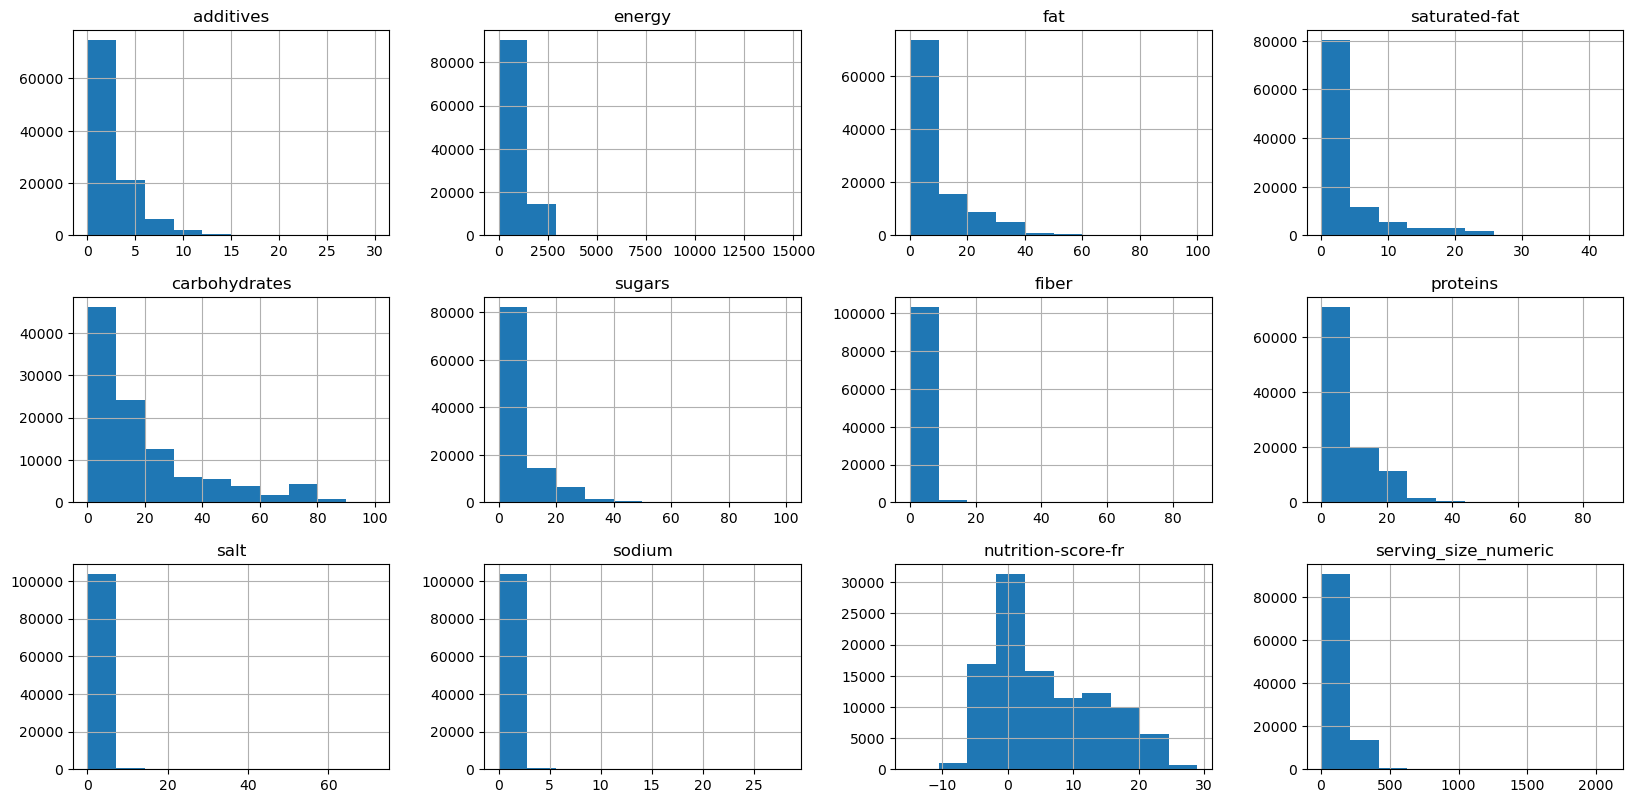

In [151]:
food_fact.hist(figsize=(20,20), layout=(6,4))
plt.show()

In [152]:
food_fact.nunique()

code                    105185
product_name             74691
brands                   20685
country                     54
ingredients_text         87317
additives                   29
nutrition_grade_fr           5
energy                    2403
fat                       2528
saturated-fat             1415
carbohydrates             4334
sugars                    2416
fiber                      527
proteins                  2058
salt                      3296
sodium                    3066
nutrition-score-fr          44
serving_size_numeric       804
serving_size_units           5
dtype: int64

In [153]:
food_fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105185 entries, 67 to 356022
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   code                  105185 non-null  object 
 1   product_name          105185 non-null  object 
 2   brands                105185 non-null  object 
 3   country               105185 non-null  object 
 4   ingredients_text      105185 non-null  object 
 5   additives             105185 non-null  float64
 6   nutrition_grade_fr    105185 non-null  object 
 7   energy                105185 non-null  float64
 8   fat                   105185 non-null  float64
 9   saturated-fat         105185 non-null  float64
 10  carbohydrates         105185 non-null  float64
 11  sugars                105185 non-null  float64
 12  fiber                 105185 non-null  float64
 13  proteins              105185 non-null  float64
 14  salt                  105185 non-null  float64
 15 

In [154]:
food_fact['country'].value_counts()

United States                83172
France                       16812
Switzerland                   1956
Germany                        982
Spain                          726
United Kingdom                 433
Australia                      274
Belgium                        144
Portugal                       132
Canada                          89
Italy                           71
Sweden                          64
Mexico                          61
Serbia                          40
New Zealand                     37
Netherlands                     36
Luxembourg                      12
Austria                         10
French Guiana                   10
Thailand                         9
Guadeloupe                       9
Hungary                          8
Poland                           8
Romania                          7
Ireland                          7
Taiwan                           7
Saint Pierre and Miquelon        7
Russia                           6
Denmark             

In [155]:
food_fact['nutrition_grade_fr'].value_counts()

b    24939
a    24527
c    23671
d    21829
e    10219
Name: nutrition_grade_fr, dtype: int64

In [156]:
columns_to_display = [
    'additives', 'energy', 'fat', 'carbohydrates', 'sugars', 
    'fiber', 'proteins', 'saturated-fat', 
    'salt', 'sodium', 'nutrition-score-fr', 'serving_size_numeric'
]
food_fact[columns_to_display].describe()

,additives,energy,fat,carbohydrates,sugars,fiber,proteins,saturated-fat,salt,sodium,nutrition-score-fr,serving_size_numeric
count,105185.000000,105185.000000,105185.000000,105185.000000,105185.000000,105185.000000,105185.000000,105185.000000,105185.000000,105185.000000,105185.000000,105185.000000
mean,1.974683,761.180103,8.299673,18.995298,5.985886,1.398039,7.445524,3.133841,1.190869,0.468846,5.725389,100.183287
std,2.525903,554.568084,11.412303,20.167900,7.777592,2.421779,8.106988,5.138974,2.684149,1.056746,8.115445,87.184940
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000
25%,0.000000,283.000000,0.100000,4.580000,0.600000,0.000000,1.180000,0.000000,0.124460,0.049000,0.000000,30.000000
50%,1.000000,644.000000,3.330000,11.760000,3.230000,0.500000,4.600000,0.620000,0.767080,0.302000,3.000000,80.000000
75%,3.000000,1167.000000,11.850000,26.190000,8.330000,2.000000,11.000000,3.850000,1.503680,0.592000,12.000000,130.000000
max,30.000000,14644.000000,100.000000,100.000000,100.000000,87.500000,87.800000,42.860000,71.582280,28.182000,29.000000,2091.000000


In [ ]:
food_fact.to_csv('food_fact.csv')